# Master Data Integration & Feature Engineering

This notebook integrates the processed FAOSTAT and World Bank datasets into a single master dataframe.

### Key Steps:
1. **Data Loading**: Load processed CSVs.
2. **Data Cleaning**: Standardise country names and remove regional aggregates.
3. **Feature Engineering**: Pivot fertilizer data, categorize crops, and merge datasets.
4. **Final Assembly**: Handle missing values and save the master dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

## 1. Load Processed Datasets

Import the cleaned data from previous steps.

In [2]:
df_yield = pd.read_csv('datasets/faostat_yield_processed.csv')
df_fert = pd.read_csv('datasets/faostat_fertilizers_processed.csv')
df_pest = pd.read_csv('datasets/faostat_pesticides_processed.csv')

In [3]:
df_wb = pd.read_csv('datasets/world bank data.csv')

In [4]:
print("Original Yield Data Shape:", df_yield.shape)
print("Original Fertilizer Data Shape:", df_fert.shape)
print("Original Pesticide Data Shape:", df_pest.shape)
print("Original World Bank Data Shape:", df_wb.shape)

Original Yield Data Shape: (160132, 8)
Original Fertilizer Data Shape: (45844, 7)
Original Pesticide Data Shape: (28516, 7)
Original World Bank Data Shape: (33096, 8)


# Feature Engineering

## 2. Country Name Standardization

Align FAOSTAT country names with World Bank naming conventions to ensure successful merging.

In [5]:
country_name_map = {
    # FAOSTAT -> World Bank naming
    'Bolivia (Plurinational State of)': 'Bolivia',
    'China, mainland': 'China',
    'China, Hong Kong SAR': 'Hong Kong SAR, China',
    'China, Macao SAR': 'Macao SAR, China',
    'China, Taiwan Province of': 'Taiwan, China',
    "Côte d'Ivoire": "Cote d'Ivoire",
    'Democratic Republic of the Congo': 'Congo, Dem. Rep.',
    'Congo': 'Congo, Rep.',
    "Democratic People's Republic of Korea": 'Korea, Dem. People\'s Rep.',
    'Republic of Korea': 'Korea, Rep.',
    'Iran (Islamic Republic of)': 'Iran, Islamic Rep.',
    'Republic of Moldova': 'Moldova',
    'Russian Federation': 'Russian Federation',
    'Syrian Arab Republic': 'Syrian Arab Republic',
    'United Republic of Tanzania': 'Tanzania',
    'Venezuela (Bolivarian Republic of)': 'Venezuela, RB',
    'Viet Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'Czechia': 'Czech Republic',
    'Eswatini': 'Eswatini',
    'North Macedonia': 'North Macedonia',
    'Bahamas': 'Bahamas, The',
    'Egypt': 'Egypt, Arab Rep.',
    'Gambia': 'Gambia, The',
    'Yemen': 'Yemen, Rep.',
    'Kyrgyzstan': 'Kyrgyz Republic',
    'Slovakia': 'Slovak Republic',
    'Lao People\'s Democratic Republic': 'Lao PDR',
}

In [6]:
df_yield['Country'] = df_yield['Country'].replace(country_name_map)
df_fert['Country'] = df_fert['Country'].replace(country_name_map)
df_pest['Country'] = df_pest['Country'].replace(country_name_map)

## 3. Filter Regional Aggregates

Remove entries that represent regions (e.g., 'World', 'Africa') rather than individual countries.

In [7]:
regional_aggregates = [
    'Africa', 'Americas', 'Asia', 'Europe', 'Oceania',
    'Eastern Africa', 'Middle Africa', 'Northern Africa', 'Southern Africa', 'Western Africa',
    'Caribbean', 'Central America', 'South America', 'Northern America',
    'Central Asia', 'Eastern Asia', 'Southern Asia', 'South-eastern Asia', 'Western Asia',
    'Eastern Europe', 'Northern Europe', 'Southern Europe', 'Western Europe',
    'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia',
    'Least Developed Countries', 'Land Locked Developing Countries',
    'Small Island Developing States', 'Low Income Food Deficit Countries',
    'Net Food Importing Developing Countries', 'World'
]

In [8]:
df_yield = df_yield[~df_yield['Country'].isin(regional_aggregates)]
df_fert = df_fert[~df_fert['Country'].isin(regional_aggregates)]
df_pest = df_pest[~df_pest['Country'].isin(regional_aggregates)]

In [9]:
print("Data after filtering:")
print(f"Yield data: {df_yield.shape}")
print(f"Fertilizer: {df_fert.shape}")
print(f"Pesticide: {df_pest.shape}")

Data after filtering:
Yield data: (127714, 8)
Fertilizer: (40552, 7)
Pesticide: (26086, 7)


## 4. Feature Engineering: Fertilizer Data

Pivot the fertilizer dataset so each nutrient becomes a distinct feature (column).

In [10]:
df_fert_pivot = df_fert.pivot_table(
    index=['Country', 'Year'], 
    columns='Fertilizer_Type', 
    values='Fertilizer_Use', 
    aggfunc='sum'
).reset_index()

df_fert_pivot.columns.name = None
new_cols = ['Country', 'Year'] + ['Fertilizer_' + col for col in df_fert_pivot.columns if col not in ['Country', 'Year']]
df_fert_pivot.columns = new_cols

## 5. Feature Engineering: Pesticide Data

Extract total pesticide use (in tonnes) for each country and year.

In [11]:
df_pest_total = df_pest[
    (df_pest['Pesticide_Type'] == 'Pesticides (total)') & 
    (df_pest['Unit'] == 't')
].copy()

df_pest_total = df_pest_total[['Country', 'Year', 'Pesticide_Use']]
df_pest_total.rename(columns={'Pesticide_Use': 'Pesticide_Total_Tonnes'}, inplace=True)

## 6. Categorize Crops

Group individual crops into broader categories (e.g., Cereals, Vegetables) to help the model learn generalizable patterns.

In [12]:
crop_categories = {
    # Cereals
    'Cereals': ['Wheat', 'Rice', 'Maize', 'Barley', 'Oats', 'Rye', 'Sorghum', 'Millet', 
                'Buckwheat', 'Quinoa', 'Fonio', 'Triticale', 'Canary seed', 'Mixed grain',
                'Cereals n.e.c.', 'Cereals, primary'],
    
    # Vegetables
    'Vegetables': ['Tomatoes', 'Onions', 'Cucumbers', 'Cabbages', 'Lettuce', 'Spinach',
                   'Carrots', 'Cauliflower', 'Pumpkins', 'Eggplants', 'Chillies and peppers',
                   'Green beans', 'Green peas', 'String beans', 'Asparagus', 'Artichokes',
                   'Leeks', 'Mushrooms', 'Okra', 'Green garlic', 'Vegetables, fresh n.e.c.'],
    
    # Fruits
    'Fruits': ['Apples', 'Oranges', 'Bananas', 'Grapes', 'Watermelons', 'Mangoes',
               'Pineapples', 'Peaches', 'Pears', 'Apricots', 'Cherries', 'Plums',
               'Strawberries', 'Raspberries', 'Blueberries', 'Kiwi', 'Papayas',
               'Dates', 'Figs', 'Avocados', 'Persimmons', 'Cashew apple',
               'Cantaloupes and other melons', 'Fruit, fresh n.e.c.'],
    
    # Legumes
    'Legumes': ['Beans', 'Peas', 'Lentils', 'Chickpeas', 'Soybeans', 'Groundnuts',
                'Pigeon peas', 'Cow peas', 'Bambara beans', 'Vetches', 'Lupins',
                'Pulses n.e.c.', 'Leguminous vegetables'],
    
    # Oil Crops
    'Oil Crops': ['Sunflower', 'Rapeseed', 'Safflower', 'Sesame', 'Linseed', 'Castor',
                  'Palm oil', 'Coconut', 'Olive', 'Oil palm fruit', 'Oilseeds n.e.c.'],
    
    # Root Crops
    'Root Crops': ['Potatoes', 'Sweet potatoes', 'Cassava', 'Yams', 'Taro', 'Yautia',
                   'Roots and tubers n.e.c.'],
    
    # Industrial Crops
    'Industrial Crops': ['Cotton', 'Jute', 'Flax', 'Hemp', 'Sisal', 'Abaca', 'Ramie',
                         'Tobacco', 'Rubber', 'Sugar cane', 'Sugar beet', 'Tea', 'Coffee',
                         'Cocoa', 'Hops', 'Fibre crops n.e.c.'],
    
    # Nuts
    'Nuts': ['Almonds', 'Walnuts', 'Hazelnuts', 'Pistachios', 'Cashew nuts', 'Brazil nuts',
             'Chestnuts', 'Areca nuts', 'Kola nuts', 'Nuts n.e.c.'],
    
    # Spices
    'Spices': ['Pepper', 'Chillies', 'Vanilla', 'Cinnamon', 'Cloves', 'Nutmeg',
               'Anise', 'Ginger', 'Spices n.e.c.'],
}

In [13]:
crop_to_category = {}
for category, crops in crop_categories.items():
    for crop in crops:
        crop_to_category[crop] = category

In [14]:
def categorize_crop(crop_name):
    # Check for exact matches first
    for category, crops in crop_categories.items():
        for crop in crops:
            if crop.lower() in crop_name.lower():
                return category
    return 'Other'

In [15]:
df_yield['Crop_Category'] = df_yield['Crop'].apply(categorize_crop)

print("Crop categories distribution:")
print(df_yield['Crop_Category'].value_counts())

Crop categories distribution:
Crop_Category
Other               49846
Vegetables          18349
Fruits              16714
Cereals             11875
Legumes             11646
Industrial Crops     6042
Root Crops           4689
Oil Crops            4166
Nuts                 2435
Spices               1952
Name: count, dtype: int64


## 7. Merge Datasets

Combine Yield, Fertilizer, Pesticide, and World Bank data into a single master dataframe.

In [16]:
# Merge Yield with Fertilizers
df_master = pd.merge(df_yield, df_fert_pivot, on=['Country', 'Year'], how='left')
print(f"After fertilizer merge: {df_master.shape}")

# Merge with Pesticides
df_master = pd.merge(df_master, df_pest_total, on=['Country', 'Year'], how='left')
print(f"After pesticide merge: {df_master.shape}")

# Merge with World Bank Data
df_master = pd.merge(df_master, df_wb, on=['Country', 'Year'], how='left')
print(f"After World Bank merge: {df_master.shape}")

After fertilizer merge: (127714, 12)
After pesticide merge: (130405, 13)
After World Bank merge: (130405, 19)


## 8. Missing Value Analysis & Handling

Analyze missing data and remove rows with incomplete information to insure data quality.

In [17]:
print(df_master.isnull().sum())

Country                                           0
Country_Code                                      0
Crop                                              0
Crop_Code                                         0
Year                                              0
Unit                                              0
Yield                                             0
Yield_scaled                                      0
Crop_Category                                     0
Fertilizer_Nutrient nitrogen N (total)          251
Fertilizer_Nutrient phosphate P2O5 (total)      251
Fertilizer_Nutrient potash K2O (total)          251
Pesticide_Total_Tonnes                         4034
ISO3                                          16815
Agricultural Land (%)                         16815
GDP (USD)                                     16815
Rainfall (mm)                                 16815
Temperature (C)                               16815
Region                                        16815
dtype: int64

In [18]:
missing_wb = df_master['ISO3'].isna().sum()
total_rows = len(df_master)

In [19]:
print(f"\nRows missing World Bank data: {missing_wb} ({(missing_wb/total_rows)*100:.1f}%)")


Rows missing World Bank data: 16815 (12.9%)


In [20]:
complete_data = df_master.dropna()

In [21]:
print(f"Rows with complete data: {len(complete_data)} ({(len(complete_data)/total_rows)*100:.1f}%)")

Rows with complete data: 109850 (84.2%)


In [22]:
print(complete_data['Yield'].describe())

count    109850.000000
mean      10041.318716
std       20709.888417
min           0.100000
25%        1003.825000
50%        3876.900000
75%       11984.950000
max      600000.000000
Name: Yield, dtype: float64


## 9. Save Master Dataset

Save the final consolidated dataset for modeling.

In [23]:
df_master.to_csv('datasets/global_master_dataset_fixed.csv', index=False)

In [24]:
df_master = df_master.dropna()

In [25]:
df_master.to_csv('datasets/global_master_dataset_fixed_with_dropna.csv', index=False)

In [26]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109850 entries, 532 to 121993
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Country                                     109850 non-null  object 
 1   Country_Code                                109850 non-null  int64  
 2   Crop                                        109850 non-null  object 
 3   Crop_Code                                   109850 non-null  int64  
 4   Year                                        109850 non-null  int64  
 5   Unit                                        109850 non-null  object 
 6   Yield                                       109850 non-null  float64
 7   Yield_scaled                                109850 non-null  float64
 8   Crop_Category                               109850 non-null  object 
 9   Fertilizer_Nutrient nitrogen N (total)      109850 non-null  float64
 10 

### Check Unique Counts (Categorical Summary)

In [29]:
df=df_master.copy()
categorical_cols = df_master.select_dtypes(include=['object']).columns

print("===== Unique Values in Categorical Columns =====")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()}")


===== Unique Values in Categorical Columns =====
Country: 175
Crop: 193
Unit: 4
Crop_Category: 10
ISO3: 175
Region: 7


### Distribution Plots for Important Numerical Features

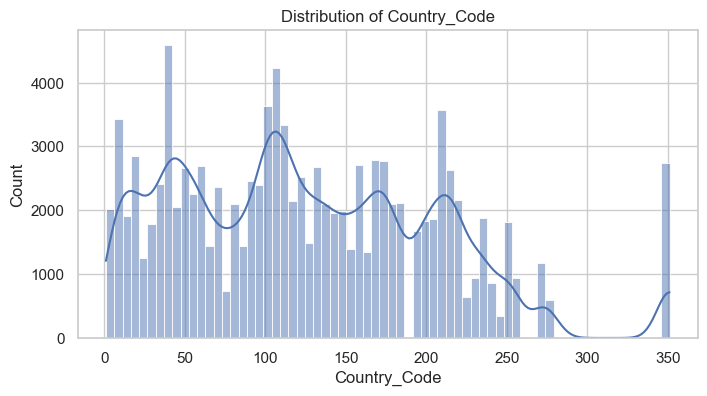

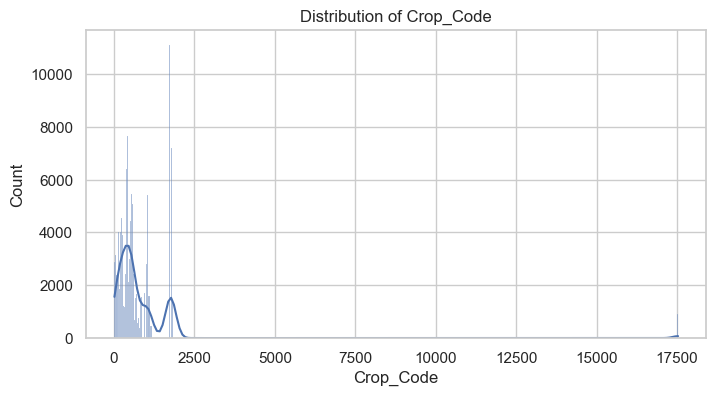

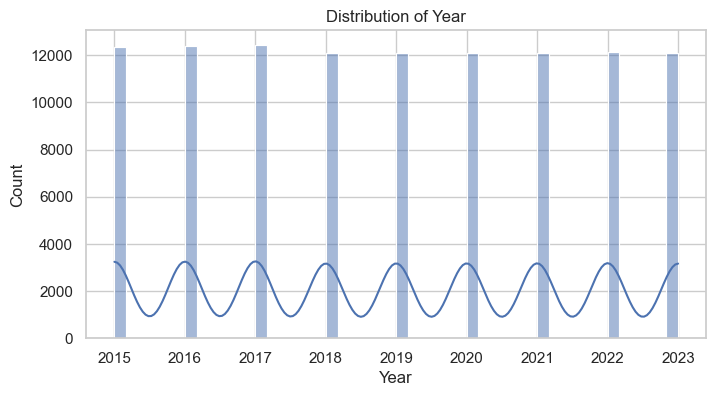

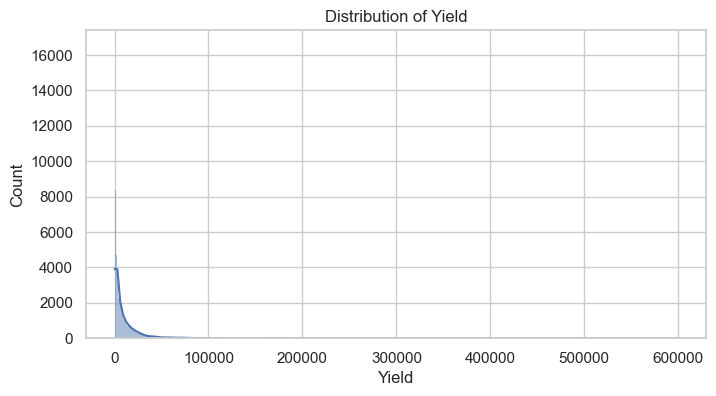

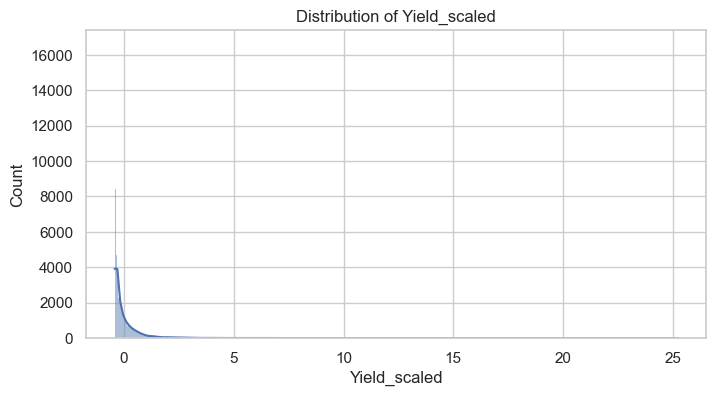

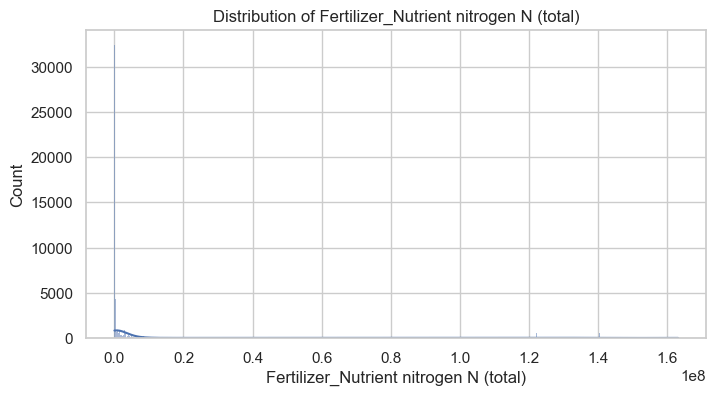

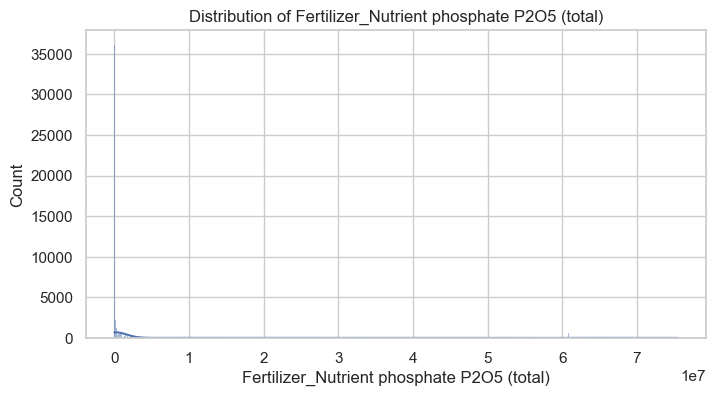

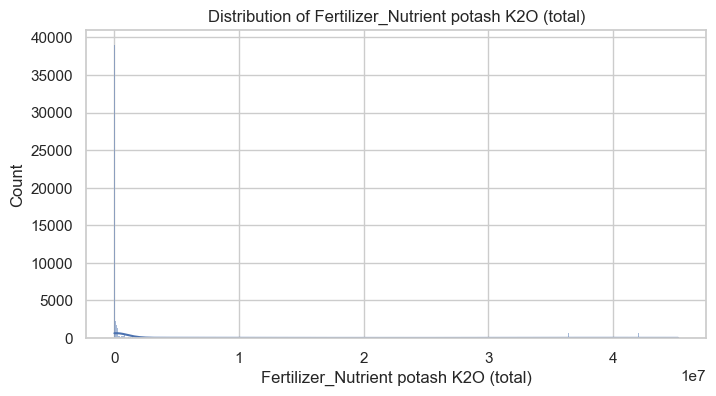

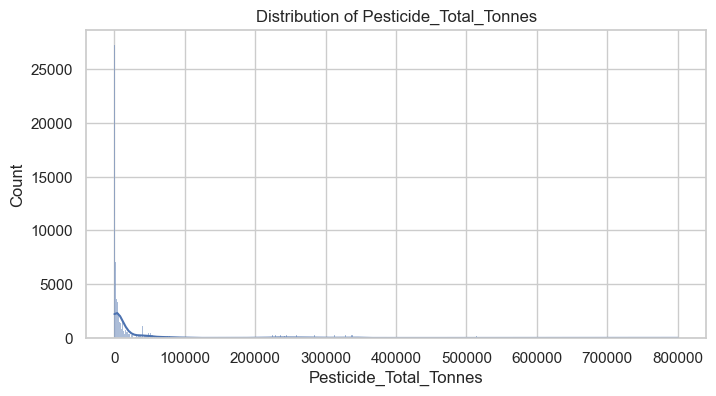

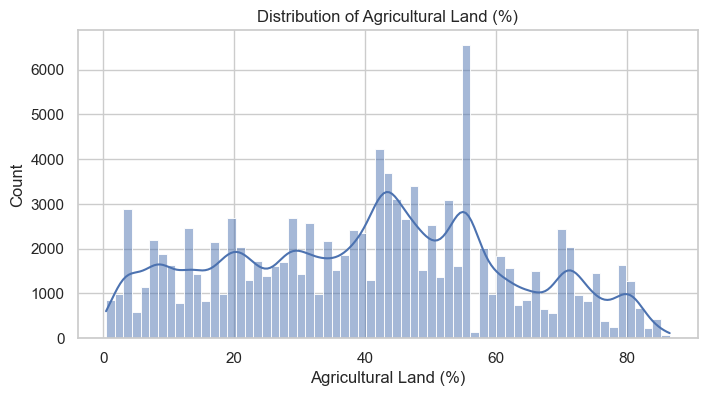

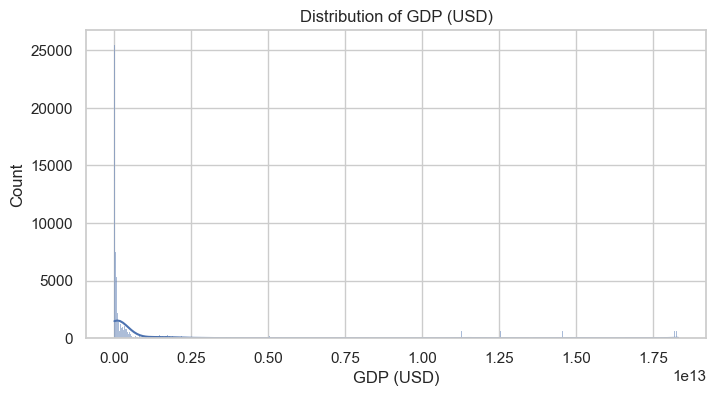

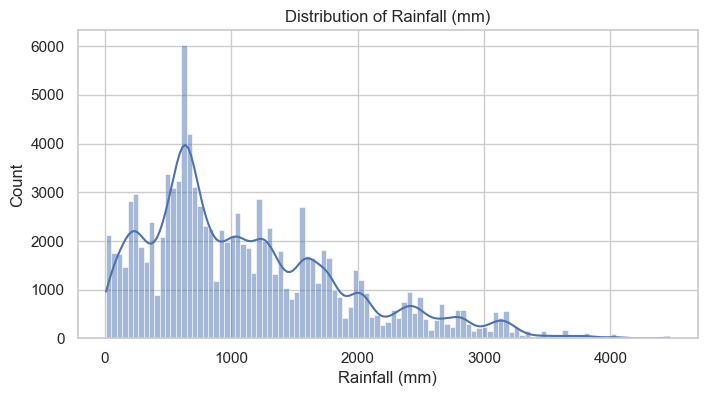

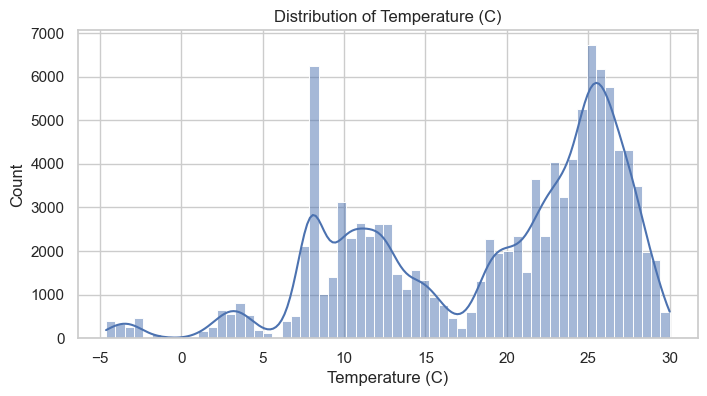

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


### Correlation Heatmap

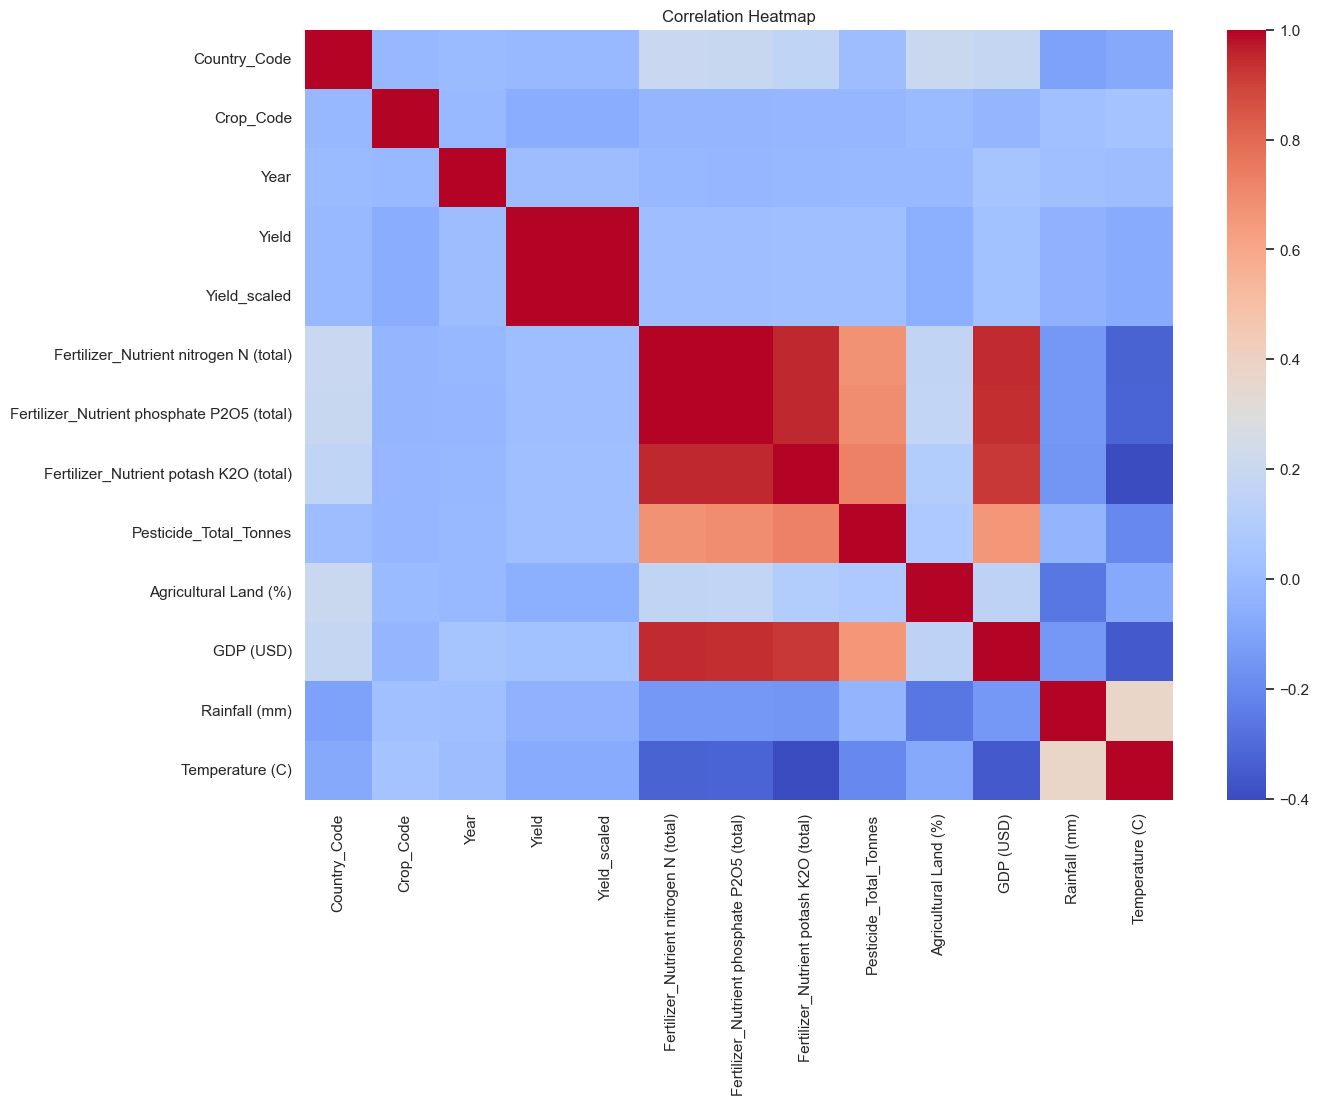

In [32]:
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


### Yield vs Key Features

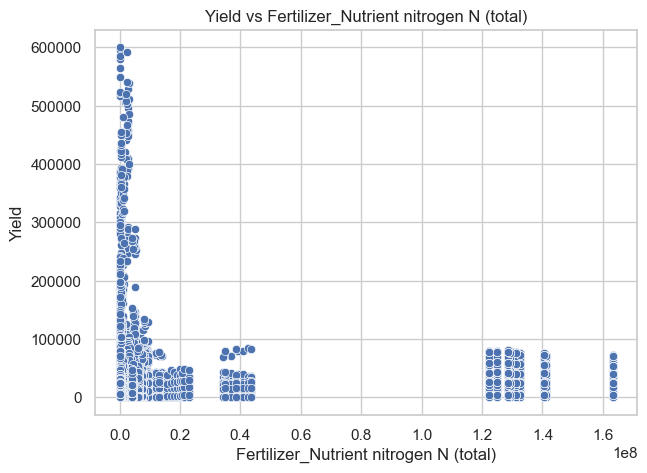

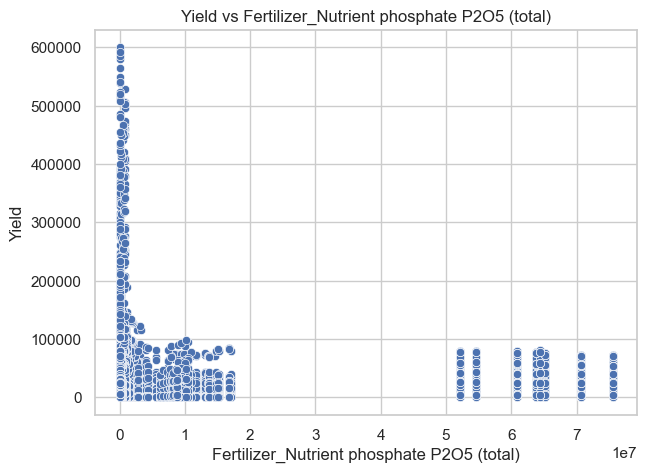

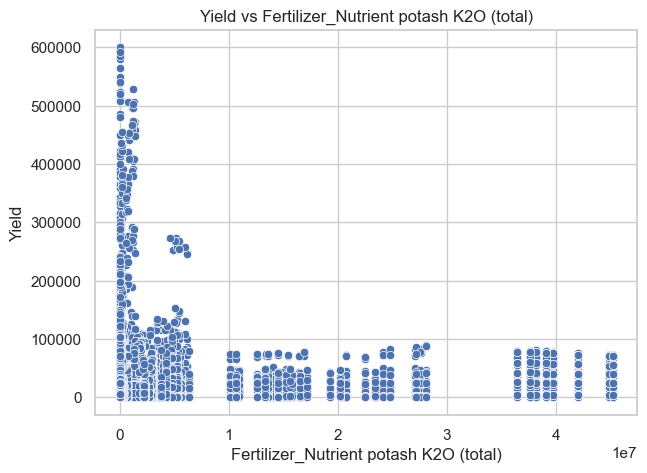

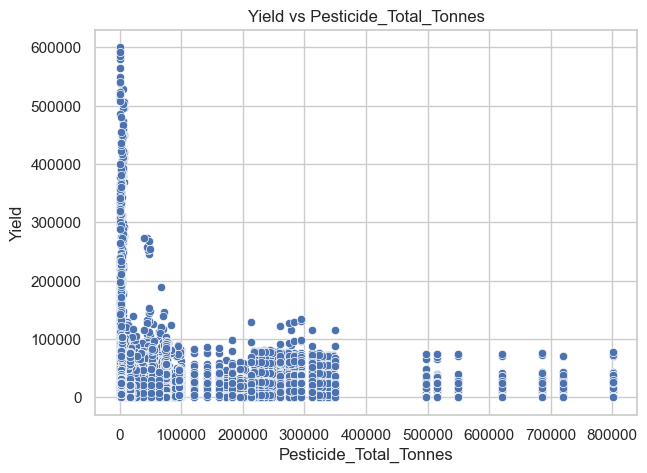

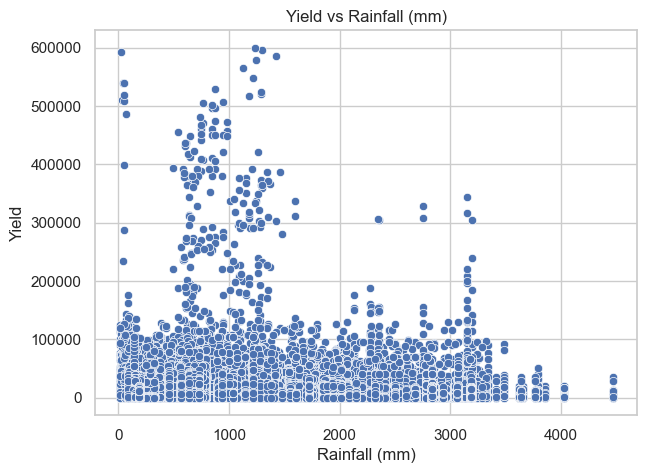

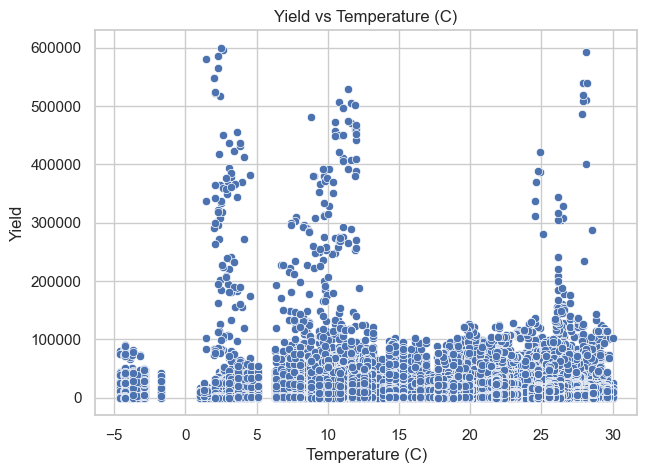

In [33]:
key_features = [
    'Fertilizer_Nutrient nitrogen N (total)',
    'Fertilizer_Nutrient phosphate P2O5 (total)',
    'Fertilizer_Nutrient potash K2O (total)',
    'Pesticide_Total_Tonnes',
    'Rainfall (mm)',
    'Temperature (C)'
]

for col in key_features:
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=df[col], y=df['Yield'])
    plt.title(f"Yield vs {col}")
    plt.show()


### Yield Distribution by Crop Category

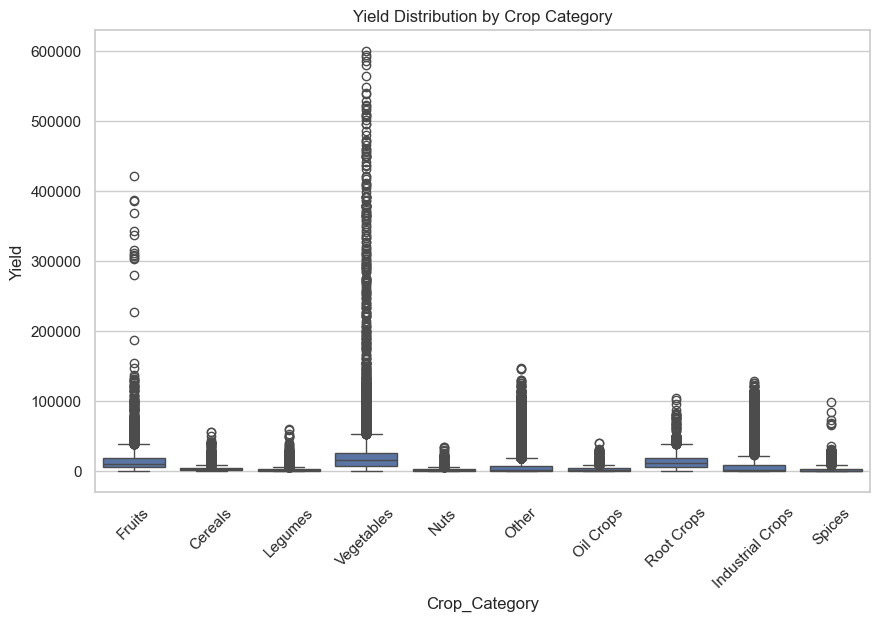

In [34]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Crop_Category', y='Yield')
plt.xticks(rotation=45)
plt.title("Yield Distribution by Crop Category")
plt.show()


### Yield by Region

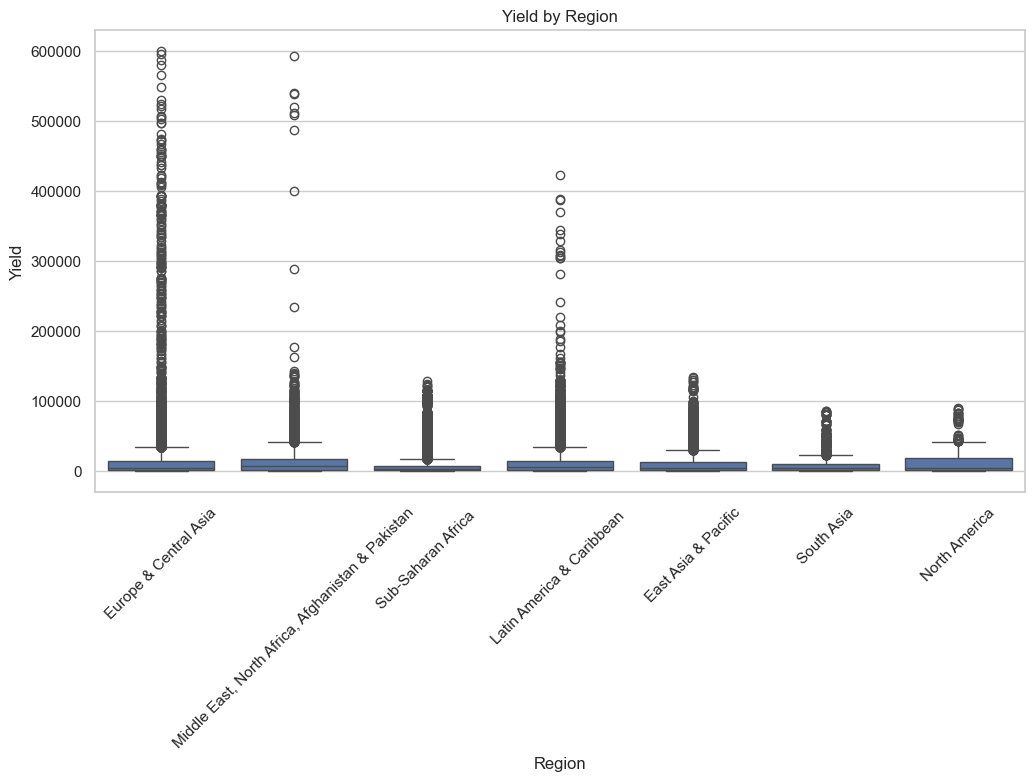

In [35]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Region', y='Yield')
plt.xticks(rotation=45)
plt.title("Yield by Region")
plt.show()


### Top 20 Crops by Frequency

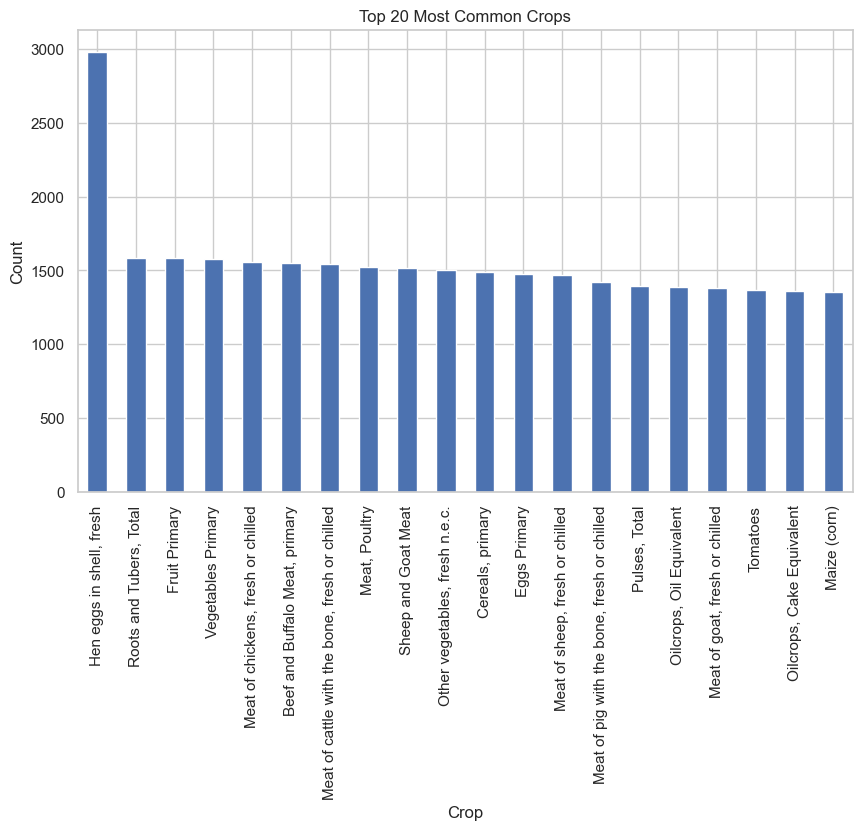

In [36]:
plt.figure(figsize=(10,6))
df['Crop'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Most Common Crops")
plt.xlabel("Crop")
plt.ylabel("Count")
plt.show()


### Trend Analysis — Yield Over Years

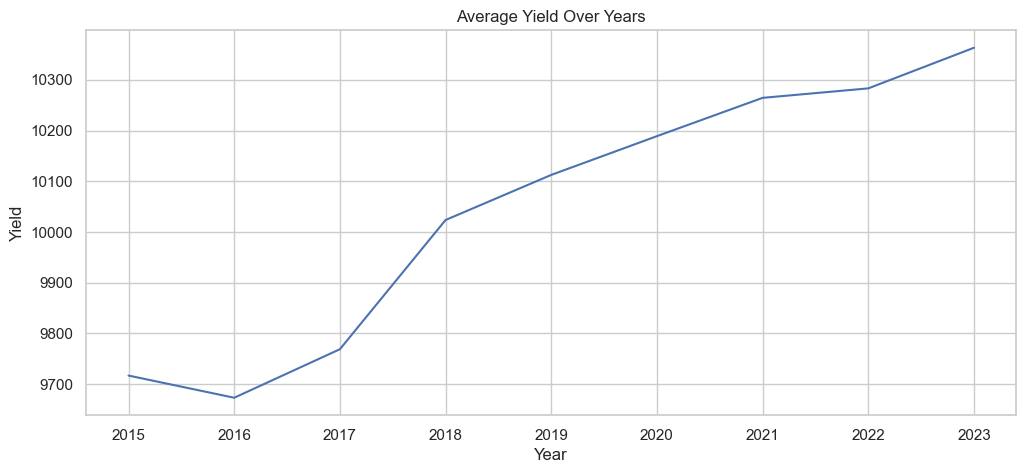

In [37]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df.groupby("Year")["Yield"].mean().reset_index(),
             x="Year", y="Yield")
plt.title("Average Yield Over Years")
plt.show()


### Country-Level Yield Distribution

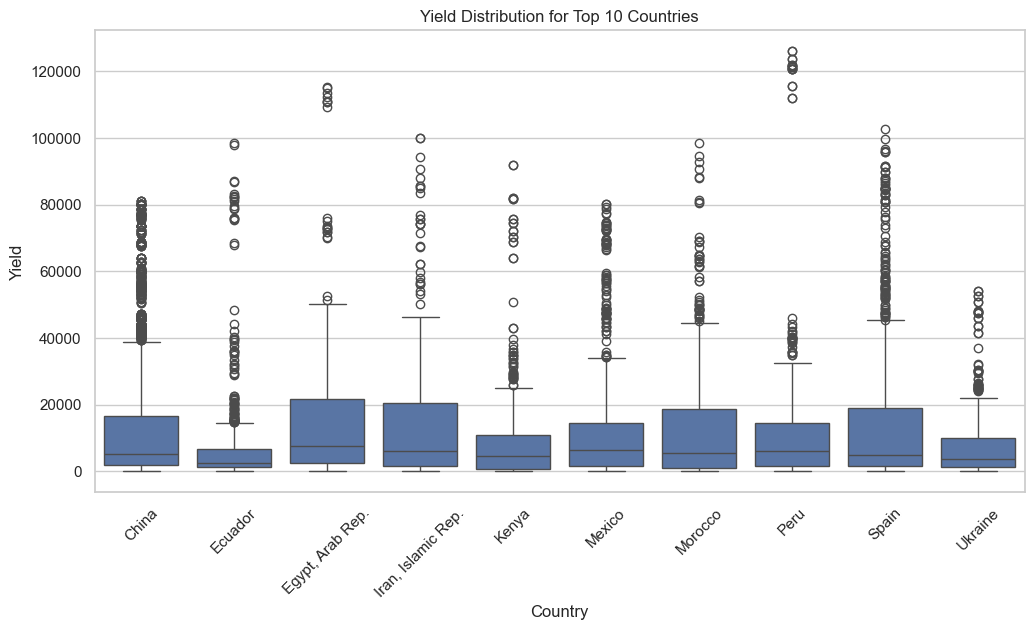

In [38]:
top_countries = df['Country'].value_counts().head(10).index

plt.figure(figsize=(12,6))
sns.boxplot(data=df[df['Country'].isin(top_countries)],
            x='Country', y='Yield')
plt.xticks(rotation=45)
plt.title("Yield Distribution for Top 10 Countries")
plt.show()
